# Task Instruction Rewriter

According the NPC background to rewrite in task instruction.

In [13]:
import csv
from io import StringIO
import requests


def get_google_spreadsheet(spreadsheet_id):
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv"
    response = requests.get(url, timeout=10)
    if response.status_code == 200:
        csv_str = response.content.decode("utf-8")
        f = StringIO(csv_str)
        spreadsheet_data = []
        reader = csv.reader(f, delimiter=",")
        next(reader, None)  # Skip the header row
        for row in reader:
            if len(row) < 4:
                continue
            name, age, gender, background = row[:4]
            if not name:
                continue
            spreadsheet_data.append(
                {"name": name, "age": age, "gender": gender, "background": background}
            )
        return spreadsheet_data
    return None

In [14]:
from pydantic import BaseModel


class Character(BaseModel):
    name: str
    age: int
    gender: str 
    background: str

npcs = get_google_spreadsheet("1VdQsc9qslvd-gGhydN5dEZEX6Q5uliBQqRguJyHBZM4")
main_character = npcs[0]
if main_character['name'] != 'main_character':
    raise ValueError("The main character's name is not 'main_character'")
main_character = Character(**main_character)

npcs = npcs[1:]
npcs.sort(key=lambda npc: npc['name'])
npcs = [Character(**npc) for npc in npcs]


In [15]:
from langchain_aws import ChatBedrock

generator_model = ChatBedrock(
    credentials_profile_name="genai",
    model_id="amazon.nova-micro-v1:0",
    model_kwargs=dict(temperature=0.5, topP=0.9),
    # other params...
)

validator_model = ChatBedrock(
    credentials_profile_name="genai",
    model_id="amazon.nova-pro-v1:0",
    model_kwargs=dict(temperature=0, topP=0.1),
    # other params...
)

ValidationError: 1 validation error for ChatBedrock
  Value error, Could not load credentials to authenticate with AWS client. Please check that credentials in the specified profile name are valid. Bedrock error:

The config profile (genai) could not be found [type=value_error, input_value={'credentials_profile_nam...use_converse_api': True}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [16]:
import operator
from typing import Annotated, List, Literal
from typing_extensions import TypedDict

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START
import re


story_prompt = f"""
## Task
Your task is to rewrite the request from an NPC (non-player character) in a video game or interactive fiction story. 
The rewritten request should be more engaging, descriptive, and fitting for the given topic and character backgrounds.

## Context

### Topic

{{topic}}

### Character Backgrounds

{{characters}}

### Original NPC request

{{raw_instruction}}

To produce a high-quality rewritten request, please follow these guidelines:

1. Read and understand the given topic, character backgrounds, and original NPC request.
2. Identify the core intent or purpose behind the original request.
3. Expand and embellish the request to make it more vivid, expressive, and aligned with the characters' personalities and backstories.
4. Incorporate relevant details, descriptions, and context from the topic and character backgrounds.
5. Maintain a consistent voice, tone, and style appropriate for the characters and story setting.
6. Ensure the rewritten request flows naturally and avoids abrupt shifts or inconsistencies.
7. Keep all placeholder "{{{{{{{{...}}}}}}}}" variables unchanged in the rewritten request.
8. Keep the length of the rewritten request within a reasonable range based on the original request.
9. Avoid introducing new characters, settings, or plot elements that are not present in the original request.
10. Keep the Language in simple and easy to understand for the target audience in age group 13-18.

Once you have carefully considered the context and guidelines, please provide your rewritten NPC request immediately without any preamble or additional text.

"""

valid_conversation_prompt = f"""
## Task
Evaluate if a given dialogue between an NPC (non-player character) and Kube has the same task meaning as the original dialogue.

## Instructions
1. Review the original dialogue provided under the "## Original Dialogue" section.
2. Review the rewritten dialogue provided under the "## Rewritten Dialogue" section.
3. Determine if the task meaning in the rewritten dialogue is included in the original dialogue.
4. If the task meaning is included, respond with "Yes" followed by your reasoning in parentheses.
5. If the task meaning is not included, respond with "No" followed by your reasoning in parentheses.

## Original Dialogue
{{raw_instruction}}

## Rewritten Dialogue
{{dialogue}}

## Response Format
Provide your response immediately without any preamble or additional information:
Yes/No. (reasoning)
"""


class OverallState(TypedDict):
    topic: str
    main_character: Character
    characters: list[Character]
    raw_instruction: str
    conversations: Annotated[list[Character], operator.add]


class StoryState(TypedDict):
    topic: str
    main_character: Character
    character: Character
    raw_instruction: str
    conversation: str


class ConversationState(TypedDict):
    conversations: list[str]


def load_characters(state: OverallState) -> OverallState:
    return state


def generate_conversation(state: StoryState) -> StoryState:
    def print_character(character: Character):
        return f"""
        Name: {character.name}
        Age: {character.age}      
        Background Story: {character.background}
        Gender: {character.gender}

"""

    main_character = print_character(state["main_character"])
    character = print_character(state["character"])
    character_str = "(Main Character)" + main_character + "(NPC)" + character
    prompt = story_prompt.format(
        topic=state["topic"],
        characters=character_str,
        raw_instruction=state["raw_instruction"],
    )
    # print(prompt)
    response = generator_model.invoke(prompt)
    conversation = response.content
    conversation = response.content.replace("\n\n", "\n")

    # print("\n\nGenerated conversation:\n\n")
    # print(conversation)
    # print("\n\n")

    return {"conversation": conversation}


def continue_to_conversation(state: OverallState) -> List[Send]:
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send(
            "generate_conversation_subgraph",
            {
                "topic": state["topic"],
                "main_character": state["main_character"],
                "character": s,
                "raw_instruction": state["raw_instruction"],
                "conversation": "",
            },
        )
        for s in state["characters"]
    ]


def valid_conversation(state: StoryState) -> ConversationState:
    # print(state)
    return {"conversations": [state["conversation"]]}


def normalize_placeholders(text: str) -> str:
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"\{\{\s*([^}]+?)\s*\}\}", r"{{\1}}", text)
    return text


def check_conversation_edge(
    state: StoryState,
) -> Literal["generate_conversation", "valid_conversation"]:
    dialogue = state["conversation"]
    raw_instruction = state["raw_instruction"]
    prompt = valid_conversation_prompt.format(
        dialogue=dialogue, raw_instruction=raw_instruction
    )

    raw_norm = normalize_placeholders(state["raw_instruction"])
    conv_norm = normalize_placeholders(dialogue)
    raw_ph = set(re.findall(r"\{\{[^}]+\}\}", raw_norm))
    conv_ph = set(re.findall(r"\{\{[^}]+\}\}", conv_norm))
    if raw_ph != conv_ph:
        # print("Placeholders mismatch!")
        return "generate_conversation"

    response = validator_model.invoke(prompt)
    # print(response.content)
    if "Yes" in response.content:
        return "valid_conversation"
    return "generate_conversation"


def all_stories(state: OverallState) -> OverallState:
    return state


generate_conversation_subgraph_builder = StateGraph(
    state_schema=StoryState, output=ConversationState
)
generate_conversation_subgraph_builder.add_node(
    "generate_conversation", generate_conversation
)
generate_conversation_subgraph_builder.add_node(
    "valid_conversation", valid_conversation
)

generate_conversation_subgraph_builder.add_edge(START, "generate_conversation")
generate_conversation_subgraph_builder.add_conditional_edges(
    "generate_conversation", check_conversation_edge
)
generate_conversation_subgraph_builder.add_edge("valid_conversation", END)
generate_conversation_subgraph = generate_conversation_subgraph_builder.compile()


generate_conversation_graph_builder = StateGraph(OverallState)
generate_conversation_graph_builder.add_node("load_characters", load_characters)
generate_conversation_graph_builder.add_node(
    "generate_conversation_subgraph", 
    
)
generate_conversation_graph_builder.add_node("all_stories", all_stories)

generate_conversation_graph_builder.add_edge(START, "load_characters")

generate_conversation_graph_builder.add_conditional_edges(
    "load_characters",
    continue_to_conversation,
    ["generate_conversation_subgraph"],
)
generate_conversation_graph_builder.add_edge(
    "generate_conversation_subgraph", "all_stories"
)

generate_conversation_graph_builder.add_edge("all_stories", END)

generate_conversation_graph = generate_conversation_graph_builder.compile()

RuntimeError: 

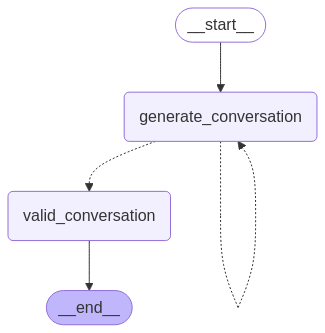

In [17]:
from IPython.display import Image

Image(generate_conversation_subgraph.get_graph(xray=True).draw_mermaid_png())


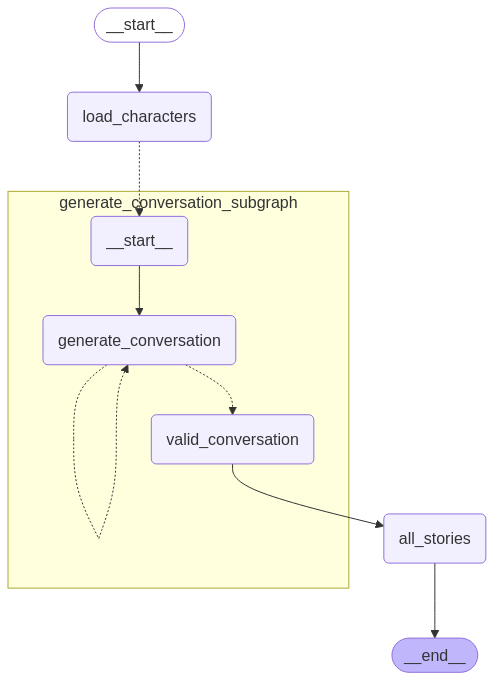

In [18]:
Image(generate_conversation_graph.get_graph(xray=True).draw_mermaid_png())

In [ ]:
import os

from session import get_instruction_template, get_tasks


output_dir = "output/rerwrite/"
os.makedirs(output_dir, exist_ok=True)

main_character.name = "Kube"
characters = npcs

game = "game01"
tasks = get_tasks(game)

for task in tasks:
    raw_instruction = get_instruction_template(game, task)
    result = None

    task_folder = os.path.join(output_dir, game, task)

    character_instructions = [
        os.path.join(task_folder, character.name, "instruction.md")
        for character in characters
    ]

    if all(os.path.exists(f) for f in character_instructions):
        print(f"Task {task} already completed")
        continue

    for s in generate_conversation_graph.stream(
        input={
            "topic": "Kubernetes Isekai (異世界)",
            "main_character": main_character,
            "characters": characters,
            "raw_instruction": raw_instruction,
        },
        config={"max_concurrency": 4},
    ):
        print(s)
        result = s

    conversations = result["all_stories"]["conversations"]

    for file_path, conversation in zip(character_instructions, conversations):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        with open(file_path, "w") as file:
            file.write(conversation)